In [1]:
import os
os.chdir("..")

In [2]:
from SSTImportanceSampling import Preprocessor, ImportanceSampler,StormDepthProcessor

In [3]:
pre = Preprocessor("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/config.json", "/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity")
pre.run()

Processing DSS files: 100%|██████████| 440/440 [14:13<00:00,  1.94s/it]


In [11]:
import pandas as pd
pd.read_parquet("./data/1_interim/Trinity/storm_centers.pq")

,storm_path,x,y
0,19790222_72hr_st1_r265,474000.0,878000.0
1,19790302_72hr_st1_r118,746000.0,838000.0
2,19790402_72hr_st1_r122,814000.0,1034000.0
3,19790411_72hr_st1_r045,646000.0,1146000.0
4,19790421_72hr_st3_r064,454000.0,794000.0
...,...,...,...
435,20220405_72hr_st1_r267,1126000.0,1166000.0
436,20220416_72hr_st3_r423,890000.0,918000.0
437,20220524_72hr_st5_r377,862000.0,854000.0
438,20220822_72hr_st3_r057,-122000.0,1074000.0


In [6]:
pre = Preprocessor.load("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity")

In [ ]:
trinity = Preprocessor.load"/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity"

In [ ]:
trinity.cumulative_precip, trinity.watershed_gdf, trinity.domain_gdf, trinity.storm_centers

In [5]:
trinity.cumulative_precip

<xarray.DataArray (storm_path: 437, y: 276, x: 440)> Size: 212MB
[53069280 values with dtype=float32]
Coordinates:
  * x           (x) float64 4kB -3.36e+05 -3.32e+05 ... 1.416e+06 1.42e+06
  * storm_path  (storm_path) object 3kB '19790222' '19790302' ... '20221228'
  * y           (y) float64 2kB 4.12e+05 4.16e+05 ... 1.508e+06 1.512e+06
Attributes:
    units:      mm
    cell_size:  4000.0
    crs:        ESRI:102039

In [7]:
trinity.domain_gdf

,id,geometry
0,1,"MULTIPOLYGON (((-263766.404 1165244.942, -2341..."


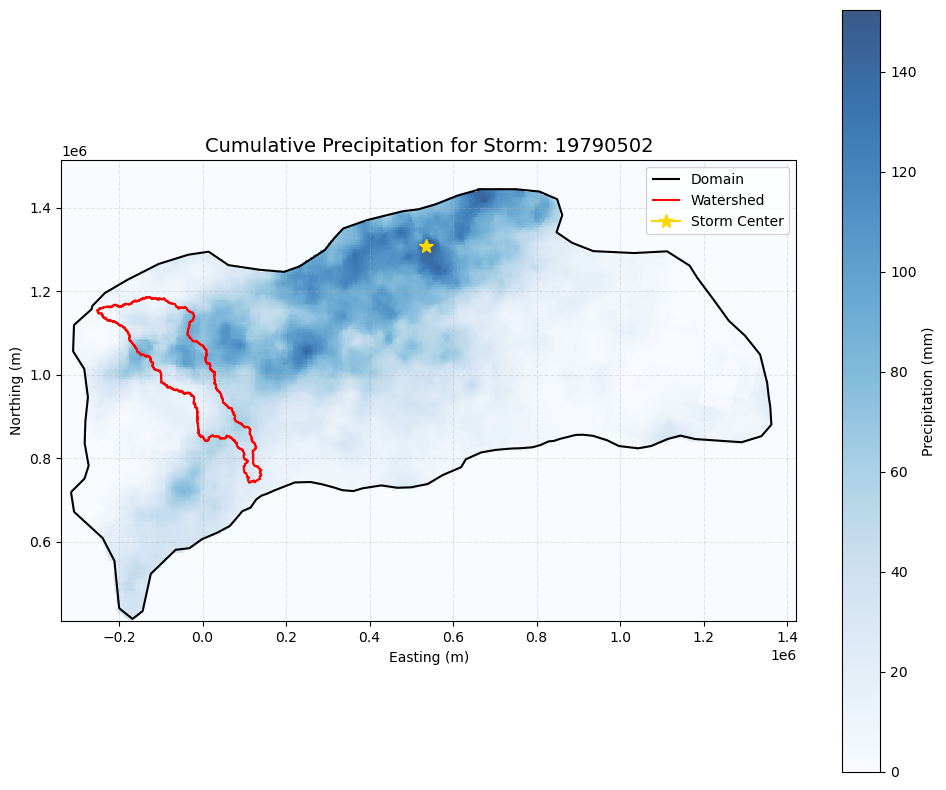

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_storm(pre, storm_name=None):
    if storm_name is None:
        storm_name = list(pre.cumulative_precip.data_vars.keys())[0]  # pick first storm
    
    precip_da = pre.cumulative_precip[storm_name]
    watershed = pre.watershed_gdf
    domain = pre.domain_gdf
    centers_df = pre.storm_centers

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot precipitation
    precip_da.plot.imshow(ax=ax, cmap="Blues", alpha=0.8, cbar_kwargs={'label': 'Precipitation (mm)'})

    # Plot domain and watershed
    domain.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, label="Domain")
    watershed.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, label="Watershed")

    # Plot storm center
    center = centers_df[centers_df["storm_path"] == storm_name]
    ax.plot(center["x"], center["y"], marker="*", color="gold", markersize=10, label="Storm Center")

    # Labels and legend
    ax.set_title(f"Cumulative Precipitation for Storm: {storm_name}", fontsize=14)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_storm(pre, storm_name="19790502")  # or just plot_storm(pre) to pick the first storm


In [13]:
pre.storm_centers

,storm_path,x,y
0,19790222,484000.0,908000.0
1,19790302,744000.0,832000.0
2,19790402,812000.0,1028000.0
3,19790411,640000.0,1136000.0
4,19790421,448000.0,788000.0
...,...,...,...
432,20220524,860000.0,852000.0
433,20220822,-124000.0,1068000.0
434,20221124,80000.0,1132000.0
435,20221213,484000.0,936000.0


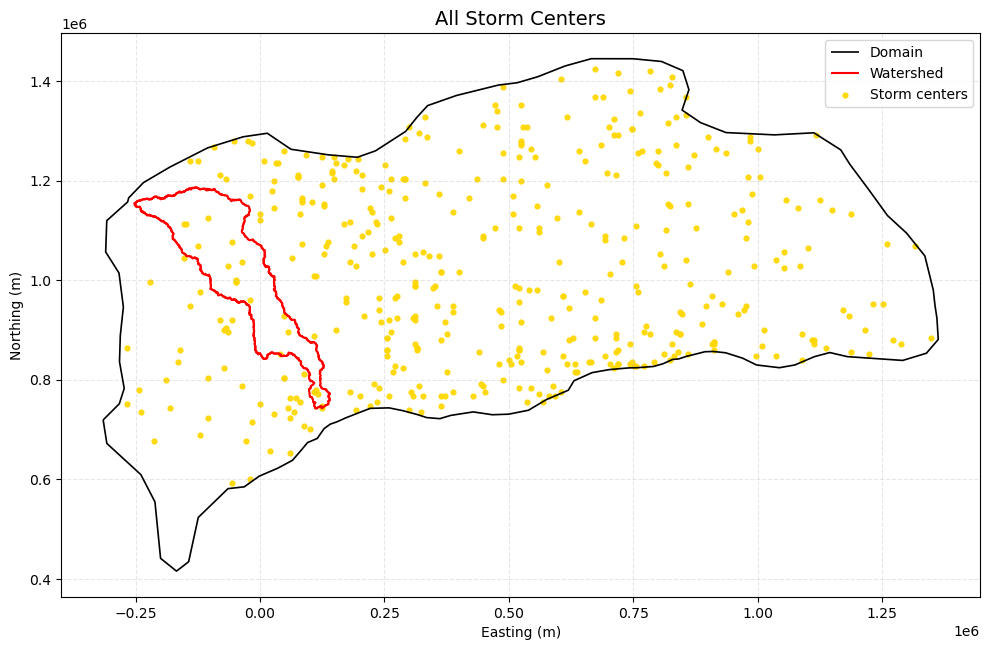

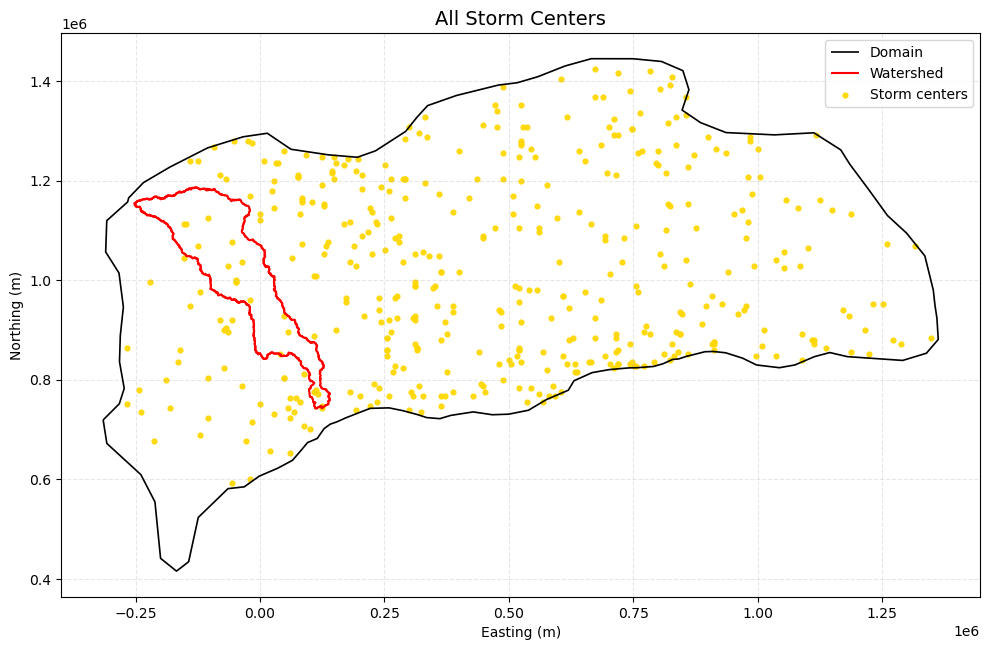

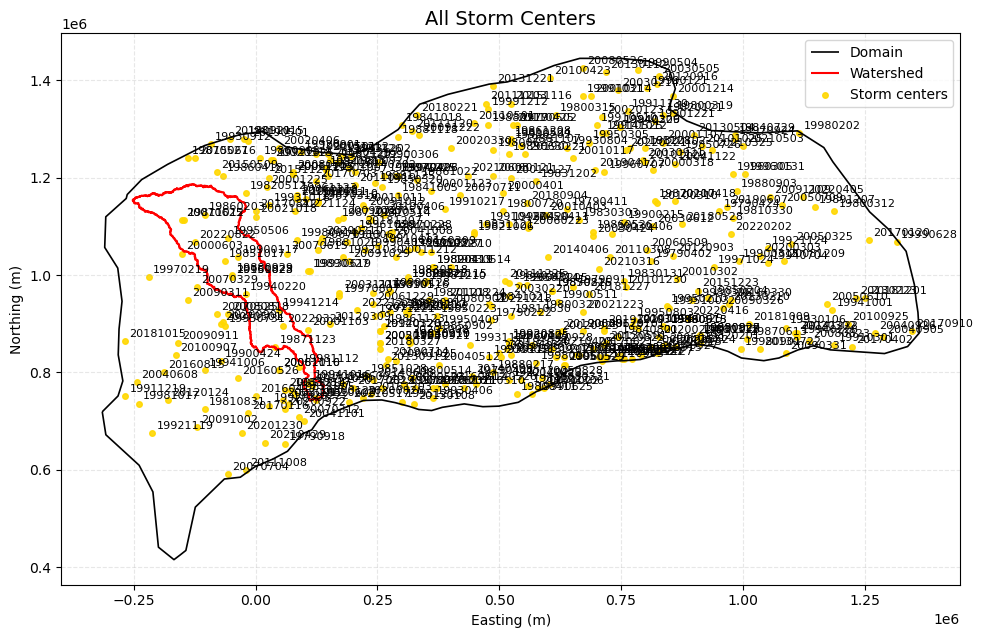

In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def plot_all_storm_centers(
    pre,
    color_by: str | None = None,   # e.g. "pmax_mm" to color by peak depth if present
    s: float = 12,                 # marker size
    annotate: bool = False,        # label each point with storm_path (can get busy)
    annotate_top: int | None = None, # if color_by given, annotate top N by that field
    title: str | None = None,
):
    """
    Plot all storm centers over domain/watershed. Optionally color by a column.

    Parameters
    ----------
    pre : Preprocessor instance (already run/loaded)
    color_by : str or None
        Column in pre.storm_centers to color points by (e.g., "pmax_mm").
    s : float
        Marker size for centers.
    annotate : bool
        If True, label each center with its storm_path (can clutter).
    annotate_top : int or None
        If set and color_by provided, only annotate the top N storms by color_by.
    title : str or None
        Custom plot title.
    """
    domain = pre.domain_gdf
    watershed = pre.watershed_gdf
    centers_df = pre.storm_centers.copy()

    # Build a GeoDataFrame of centers
    centers_gdf = gpd.GeoDataFrame(
        centers_df,
        geometry=gpd.points_from_xy(centers_df["x"], centers_df["y"]),
        crs=domain.crs
    )

    fig, ax = plt.subplots(figsize=(10, 8))

    # Boundaries
    domain.boundary.plot(ax=ax, color="black", linewidth=1.2, label="Domain")
    watershed.boundary.plot(ax=ax, color="red", linewidth=1.5, label="Watershed")

    # Scatter of centers
    if color_by is not None and color_by in centers_gdf.columns:
        sc = centers_gdf.plot(
            ax=ax,
            column=color_by,
            cmap="viridis",
            markersize=s,
            alpha=0.9,
            legend=True,
            legend_kwds={"label": color_by}
        )
    else:
        sc = centers_gdf.plot(
            ax=ax,
            color="gold",
            markersize=s,
            alpha=0.9,
            label="Storm centers"
        )

    # Optional annotations
    if annotate:
        df_to_annotate = centers_gdf
        if annotate_top is not None and color_by is not None and color_by in centers_gdf.columns:
            df_to_annotate = centers_gdf.sort_values(color_by, ascending=False).head(int(annotate_top))
        for _, r in df_to_annotate.iterrows():
            ax.annotate(
                str(r["storm_path"]),
                (r.geometry.x, r.geometry.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8
            )

    ax.set_aspect("equal")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="upper right")

    if title is None:
        title = "All Storm Centers"
        if color_by is not None and color_by in centers_gdf.columns:
            title += f" (colored by {color_by})"
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

# Simple plot of all centers
plot_all_storm_centers(pre)

# Color by peak cumulative precip (if you stored pmax_mm)
plot_all_storm_centers(pre, color_by="pmax_mm")

# Color by pmax and annotate top 10 biggest
plot_all_storm_centers(pre, color_by="pmax_mm", annotate=True, annotate_top=10, s=16)

In [8]:
sampler = Sampler(
    distribution="uniform",
    params = {},
    num_simulations=5000,
    num_rep=5,
)

samples_df = sampler.sample(pre.domain_gdf, pre.watershed_gdf)

In [15]:
samples_df

,rep,event_id,x,y,weight
0,1,1,8.359603e+05,1.251380e+06,0.0002
1,1,2,5.128584e+05,9.219494e+05,0.0002
2,1,3,1.010478e+06,1.103647e+06,0.0002
3,1,4,6.264484e+05,1.060589e+06,0.0002
4,1,5,-6.691569e+04,1.030561e+06,0.0002
...,...,...,...,...,...
24995,5,4996,8.862389e+05,1.099586e+06,0.0002
24996,5,4997,3.414113e+05,9.431305e+05,0.0002
24997,5,4998,3.877599e+05,1.351459e+06,0.0002
24998,5,4999,6.623828e+05,1.007386e+06,0.0002


In [19]:
samples_df[samples_df["rep"] == 1]["weight"].sum()

np.float64(0.9998000399920013)

In [21]:
processor = StormDepthProcessor(
    precip_cube=pre.cumulative_precip,
    storm_centers=pre.storm_centers,
    watershed_gdf=pre.watershed_gdf,
    arrival_rate=10  # average storms per year
)

In [22]:
result_df = processor.shift_and_extract_precip(
    df_storms=samples_df,
    n_jobs=-1,     # Use all cores
    seed=42        # For reproducibility
)

In [23]:
result_df

,event_id,x,y,weight,storm_path,precip_avg_mm,rep,exc_prb,return_period
0,3983,5.288959e+04,1.134601e+06,0.0002,19790918,141.046988,1,0.0002,500.600167
1,4537,5.504225e+04,1.164144e+06,0.0002,19790918,139.508955,1,0.0004,250.550333
2,4458,1.688495e+04,1.093217e+06,0.0002,19790918,137.593080,1,0.0006,167.200500
3,2988,3.043350e+04,1.103919e+06,0.0002,19790918,137.293186,1,0.0008,125.525667
4,3743,6.288246e+04,1.174630e+06,0.0002,19790918,136.640350,1,0.0010,100.520833
...,...,...,...,...,...,...,...,...,...
24995,2227,8.277763e+05,8.636506e+05,0.0002,19790911,0.000000,5,0.9990,1.000046
24996,2230,1.018899e+06,9.686795e+05,0.0002,19790502,0.000000,5,0.9992,1.000046
24997,4151,1.252740e+06,9.061964e+05,0.0002,19790911,0.000000,5,0.9994,1.000046
24998,4156,5.500565e+05,1.371219e+06,0.0002,19790918,0.000000,5,0.9996,1.000046


In [12]:
result_df.to_csv("results.csv")

In [14]:
from scipy.stats import uniform
num_simulations = 10000
bounds = pre.domain_gdf.total_bounds
minx, miny, maxx, maxy = bounds
range_x = maxx - minx
range_y = maxy - miny

dist_x = uniform(minx, range_x)
dist_y = uniform(miny, range_y)
x = dist_x.rvs(num_simulations)
y = dist_y.rvs(num_simulations)

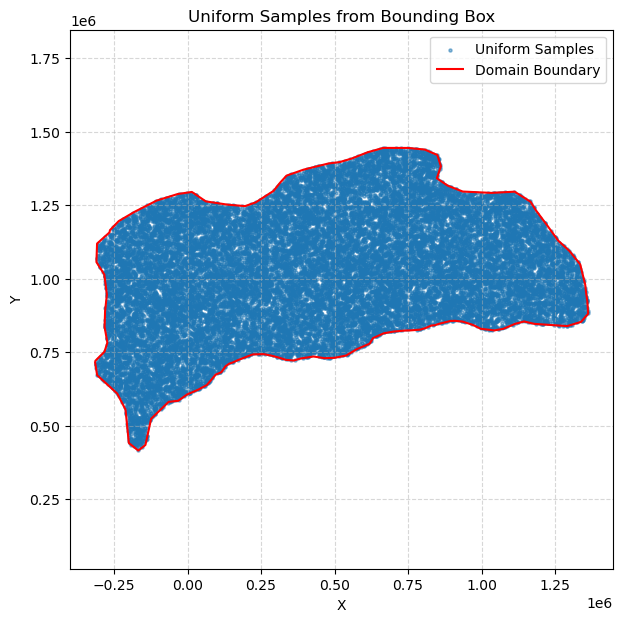

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(result_df["x"], result_df["y"], s=5, alpha=0.5, label="Uniform Samples")
pre.domain_gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1.5, label="Domain Boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Uniform Samples from Bounding Box")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.axis("equal")
plt.show()